In [95]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import math
import dLux as dl
import dLux.utils as dlu
from matplotlib import colors, pyplot as plt
import jax.numpy as np
import numpy as onp
from jax import jit, vmap
import jax.random as jr

from poppy.zernike import hexike_basis

import webbpsf
import webbpsf.constants as const
from astropy.io import fits
import astropy.units as u
from tqdm.notebook import tqdm
from numpyro.infer.util import log_likelihood

from dLuxWebbpsf import NIRCam

## Phase retrieval 

In [32]:
def jwst_hexike_bases(nterms, npix, instrument):
    import poppy
    import numpy as onp

    # Get webbpsf model
    seg_rad = const.JWST_SEGMENT_RADIUS  # TODO check for overlapping pixels
    amplitude_plane = 0
    keys = const.SEGNAMES_WSS  # all mirror segments

    osys = instrument.get_optical_system()
    seg_cens = dict(const.JWST_PRIMARY_SEGMENT_CENTERS)
    pscale = osys.planes[0].pixelscale.value * 1024 / npix

    # Scale mask
    transmission = osys.planes[amplitude_plane].amplitude
    mask = dl.utils.scale_array(transmission, npix, 1)

    # Generating a basis for each segment
    bases = []
    for key in keys:  # cycling through segments
        centre = np.array(seg_cens[key])
        rhos, thetas = onp.array(dlu.pixel_coordinates((npix, npix), pscale, offsets=tuple(centre), polar=True))
        bases.append(hexike_basis(nterms, npix, rhos / seg_rad, thetas, outside=0.0))  # appending basis

    return mask, np.array(bases), pscale

In [96]:
def jwst_hexike_bases1(nterms, npix, pscale):
    # Get webbpsf model
    seg_rad = const.JWST_SEGMENT_RADIUS  # TODO check for overlapping pixels
    keys = const.SEGNAMES_WSS  # all mirror segments

    seg_cens = dict(const.JWST_PRIMARY_SEGMENT_CENTERS)

    # Generating a basis for each segment
    bases = []
    for key in keys:  # cycling through segments
        centre = np.array(seg_cens[key])
        rhos, thetas = onp.array(dlu.pixel_coordinates((npix, npix), pscale, offsets=tuple(centre), polar=True))
        bases.append(hexike_basis(nterms, npix, rhos / seg_rad, thetas, outside=0.0))  # appending basis

    return np.array(bases)

In [42]:
def gen_JWST_mask_basis(nterms, npix, instrument):
    import poppy
    import numpy as onp
    
    ins_osys = instrument.get_optical_system()
    seg_cens = ins_osys.planes[0]._seg_centers_m
    pscale = ins_osys.planes[0].pixelscale.value * 1024 / npix
    
    # Scale mask
    pupil = ins_osys.planes[0].amplitude
    mask = dl.utils.scale_array(pupil, npix, 1)
    
    # Hard-coded scaling params
    diam = 1.32 * 1.001
    
    # Gen basis
    bases = []
    for key in seg_cens.keys():
        xcen, ycen = -seg_cens[key]
        rho, theta = onp.array(dlu.pixel_coordinates((npix,npix), pscale, (xcen, ycen), polar=True))
        bases.append(hexike_basis(nterms, npix, diam*rho, theta, outside=0.))
        
    return mask, np.array(bases)

In [99]:
npix_basis = 512
nterms = 6

(18, 6, 512, 512)


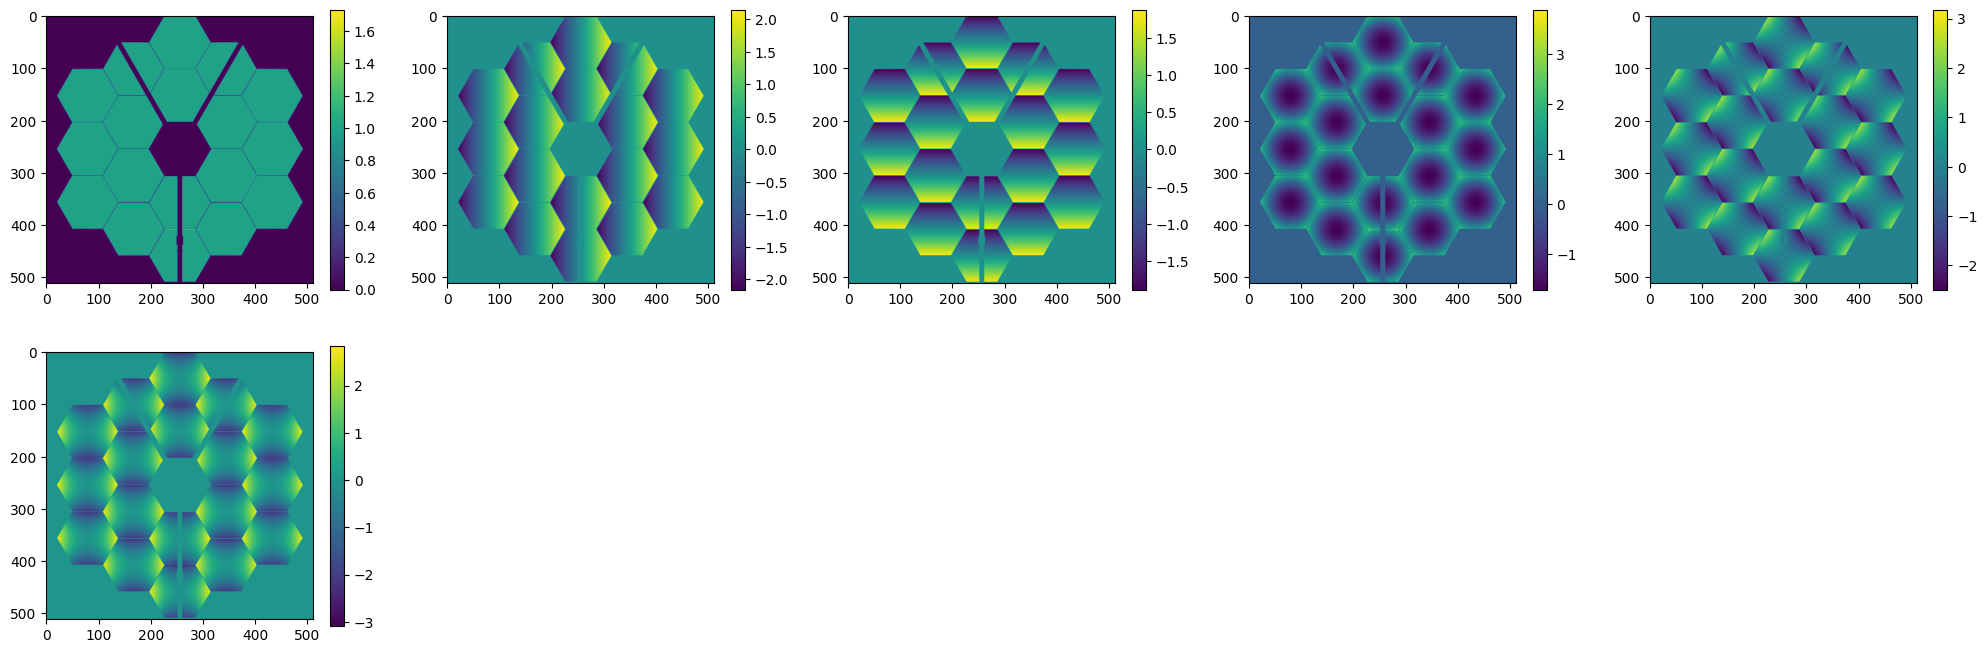

In [100]:
nircam = webbpsf.NIRCam()
osys = nircam.get_optical_system()
pupil = osys.planes[0]
pscale = pupil.pixelscale.value * 1024 / npix_basis

mask = dl.utils.scale_array(pupil.amplitude, npix_basis, 1)

basis = jwst_hexike_bases1(nterms, npix_basis, pscale)

print(basis.shape)

sample_basis = mask*basis.sum(0)
plt.figure(figsize=(25, 8))
for i in range(len(basis[0])):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_basis[i])
    plt.colorbar()
plt.show()

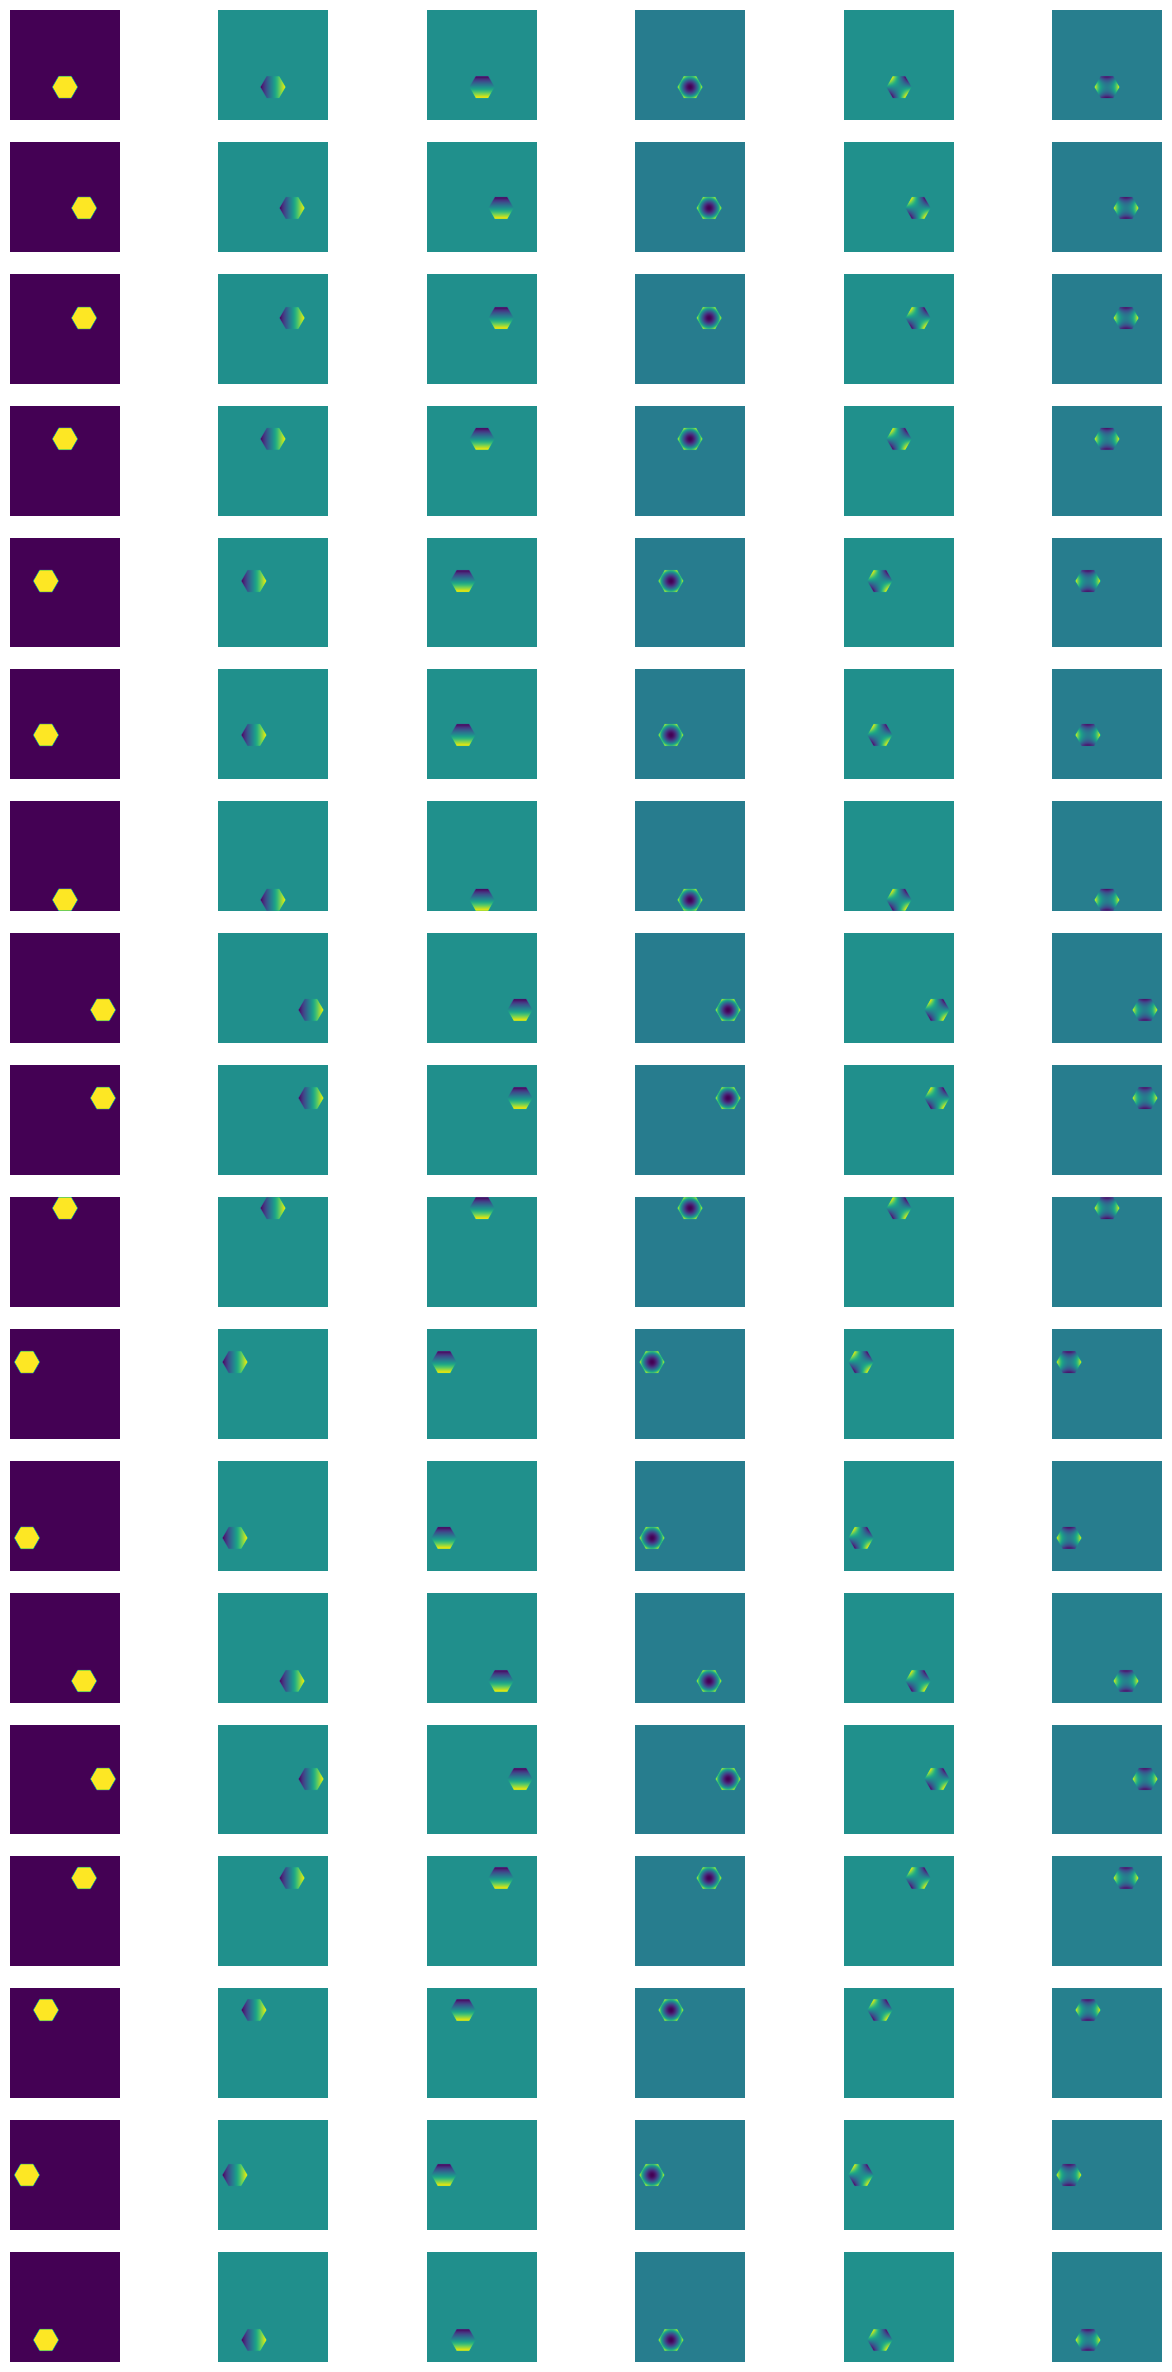

In [105]:
fig, axes = plt.subplots(18, nterms) #, figsize=(12, 9))

basis_flat = basis.reshape((nterms*18, npix_basis, npix_basis))

for j in range(basis_flat.shape[0]):
    ax = axes.ravel()[j]
    ax.set_axis_off()
    ax.imshow(basis_flat[j,:,:])
    
plt.subplots_adjust(left=0.05, right=1.95, top=4.95, bottom=0.05)

(18, 10, 1024, 1024)


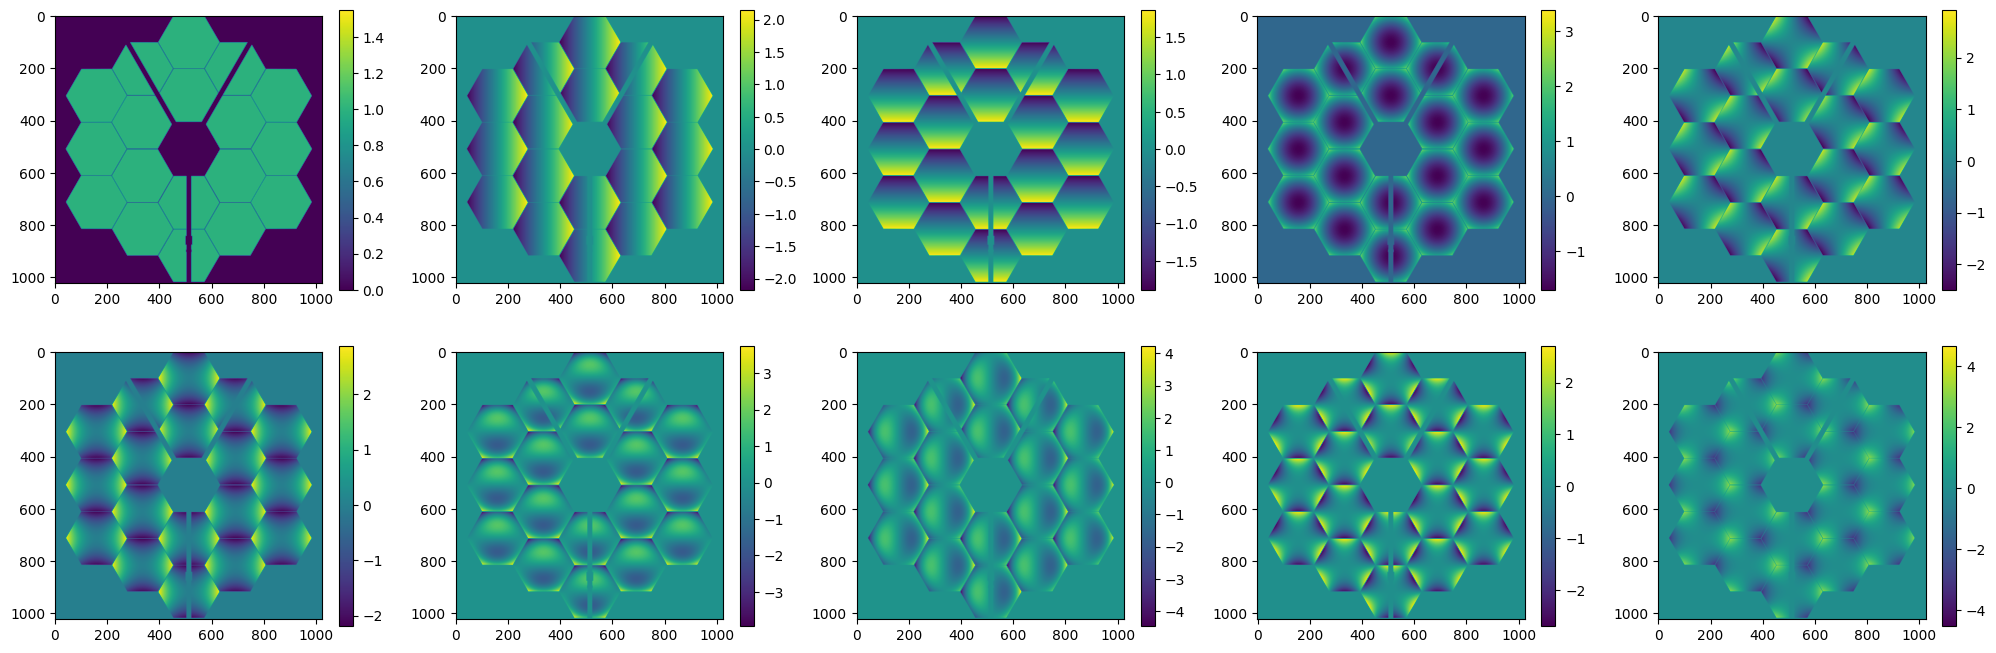

In [41]:
mask, basis, pscale = jwst_hexike_bases(nterms, npix_basis, nircam)
print(basis.shape)
sample_basis = mask*basis.sum(0)
plt.figure(figsize=(25, 8))
for i in range(len(basis[0])):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_basis[i])
    plt.colorbar()
plt.show()

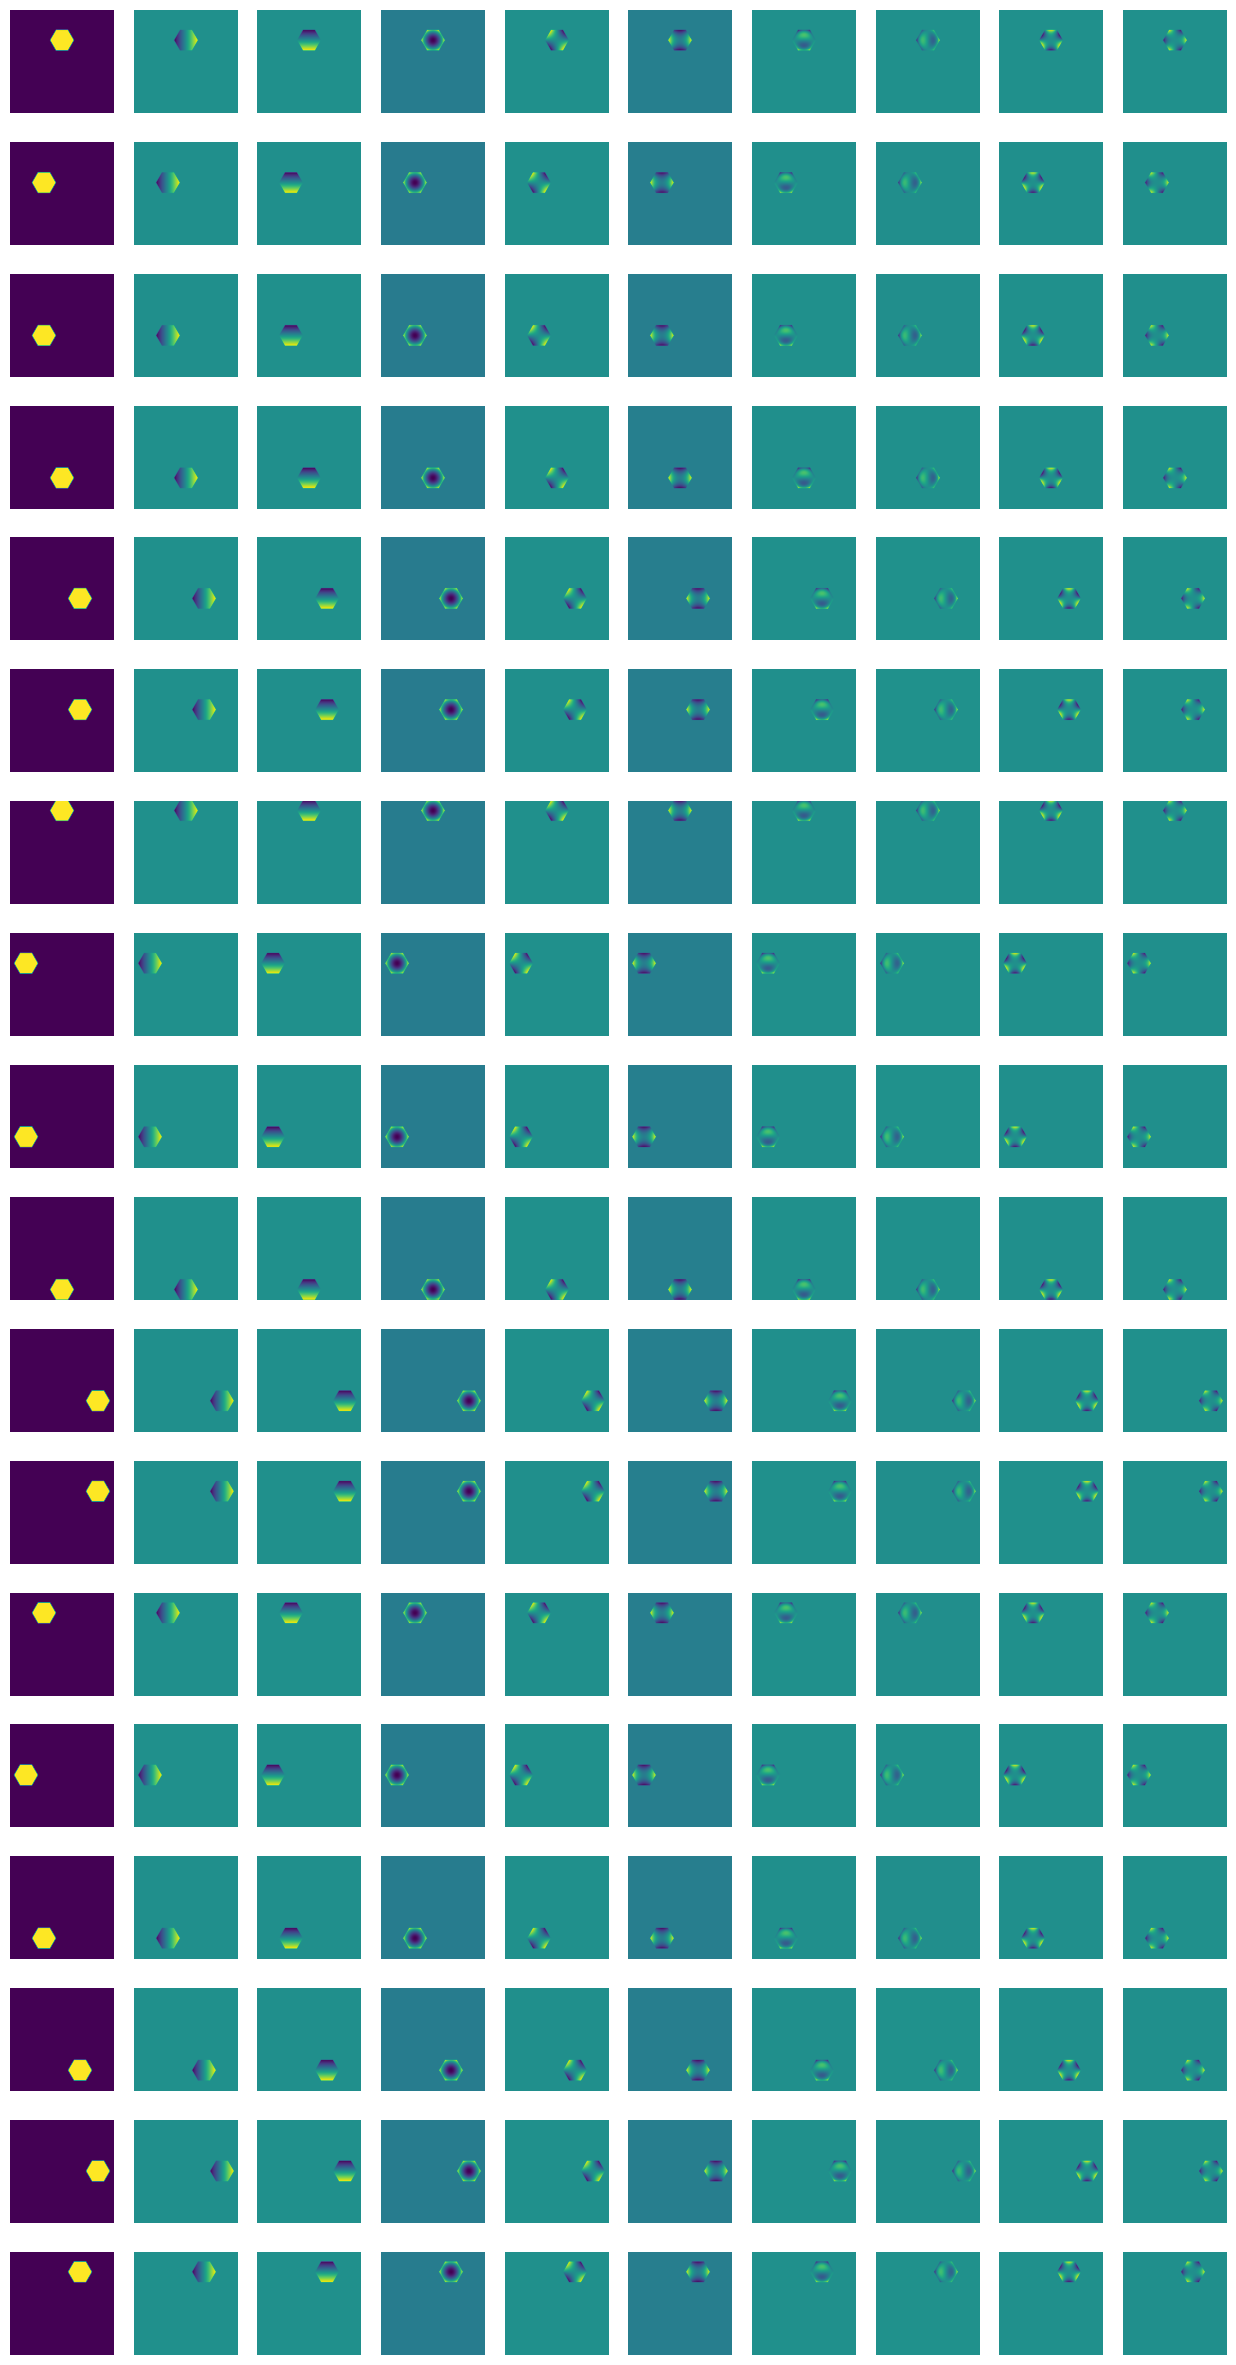

In [82]:
fig, axes = plt.subplots(18, nterms) #, figsize=(12, 9))

basis_flat = basis.reshape((nterms*18, npix_basis, npix_basis))

for j in range(basis_flat.shape[0]):
    ax = axes.ravel()[j]
    ax.set_axis_off()
    ax.imshow(basis_flat[j,:,:])
    
plt.subplots_adjust(left=0.05, right=1.95, top=4.95, bottom=0.05)

In [102]:
fix_n = 0

In [103]:
seed = 0xDEFDBE3F
coeffs = 2e-8*jr.normal(jr.PRNGKey(seed), (basis_flat.shape[0],))
coeffs = coeffs.at[fix_n].set(0)

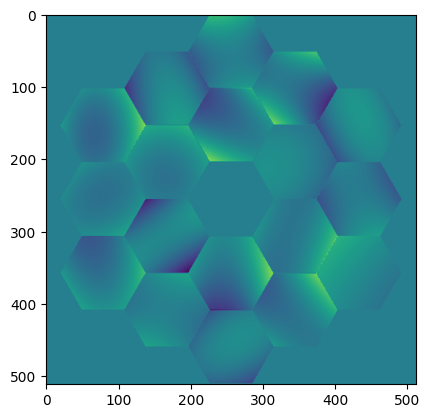

In [104]:
def get_aber(coeffs, basis):
    coeffs_reshaped = coeffs.reshape(coeffs.shape[0], 1, 1)
    s_coeffs = np.asarray(coeffs.reshape(coeffs.shape[0], 1, 1), dtype=float)
    s_basis = np.asarray(basis, dtype=float)
    result = s_coeffs * s_basis
    return result.sum(0)

base_aberrations = get_aber(coeffs, basis_flat)
plt.imshow(base_aberrations)

In [49]:
base_aberrations.shape

(1024, 1024)

In [37]:
class JWST_basis(OpticalLayer):
    
    basis: None
    coeffs: None
    
    def __init__(self, basis, coeffs, fix_n=0):
        super().__init__("JWST_basis")
        
        self.basis = np.asarray(basis, dtype=float)
        self.coeffs = np.asarray(coeffs, dtype=float)
    
    def __call__(self, wavefront):
        coeffs_reshaped = self.coeffs.reshape(self.coeffs.shape[0], 1, 1)
        
        opd_arr = self.basis * coeffs_reshaped
        opd = opd_arr.sum(0)
        
        return wavefront.add_opd(opd)
    

In [39]:
#webb_osys = get_nircam()
nircam = webb_osys.optsys
pupil_plane = nircam.planes[0]
det_plane = nircam.planes[-1]

In [40]:
# Wavefront 
npix = 1024
diameter = pupil_plane.pixelscale.to('m/pix').value * pupil_plane.npix
# diameter == 6.603464

# Aperture and OPD
webb_aper = nircam.planes[0].amplitude
webb_opd = nircam.planes[0].opd
pupil_mask = nircam.planes[3].amplitude

# Detector
det_npix = (det_plane.fov_pixels * det_plane.oversample).value
print(det_npix)
pscale = det_plane.pixelscale/det_plane.oversample
print(pscale)
pscale = pscale.to('radian/pix').value

# pscale == 7.958548e-08

# Make layers

def get_optical_layers():
    optical_layers = [
        
        
        #Plane 0: Pupil plane: JWST Entrance Pupil
        dl.CreateWavefront(npix, diameter, 'Angular'),
        dl.TransmissiveOptic(webb_aper),
        dl.AddOPD(webb_opd),
        JWST_basis(basis_flat, coeffs),

        #Plane 1: Coordinate Inversion in y axis
        InvertY(),

        #Plane 2: Pupil plane: NIRCamLWA internal WFE at V2V3=(1.46,-6.75)', near Z430R_A
        #dl.AddOPD(nircam.planes[4].get_opd(wavel)),
        dl.TransmissiveOptic(nircam.planes[2].amplitude),
        NIRCamFieldAndWavelengthDependentAberration(webb_osys, nircam.planes[2].opd, nircam.planes[2].zernike_coeffs),
        

        #Plane 3: Detector plane: NIRCam detector (79x79 pixels, 0.063 arcsec / pix)
        dl.AngularMFT(det_npix, pscale),         
        
    ]
    return optical_layers

optical_layers = get_optical_layers()

optics = dl.Optics(optical_layers)

telescope = dl.Instrument(optics, source)

@jit
def model_optics_jit():
    return telescope.model()


316.0
0.01575 arcsec / pix


In [41]:
%%time
print("Modelling optics...")
psf = model_optics_jit()
print("Modelling optics...ok")
psf_norm = psf/psf.sum()
webbpsf_norm = webbpsf_data/webbpsf_data.sum()

norm = colors.LogNorm(vmin=1e-10, vmax=1e-5)
vmin = 1e-10
vmax = 1e-5
ticks = np.logspace(np.log10(vmin), np.log10(vmax), int(np.round(np.log10(vmax / vmin) + 1)))

Modelling optics...
Modelling optics...ok
CPU times: user 6.02 s, sys: 2.14 s, total: 8.16 s
Wall time: 2.32 s


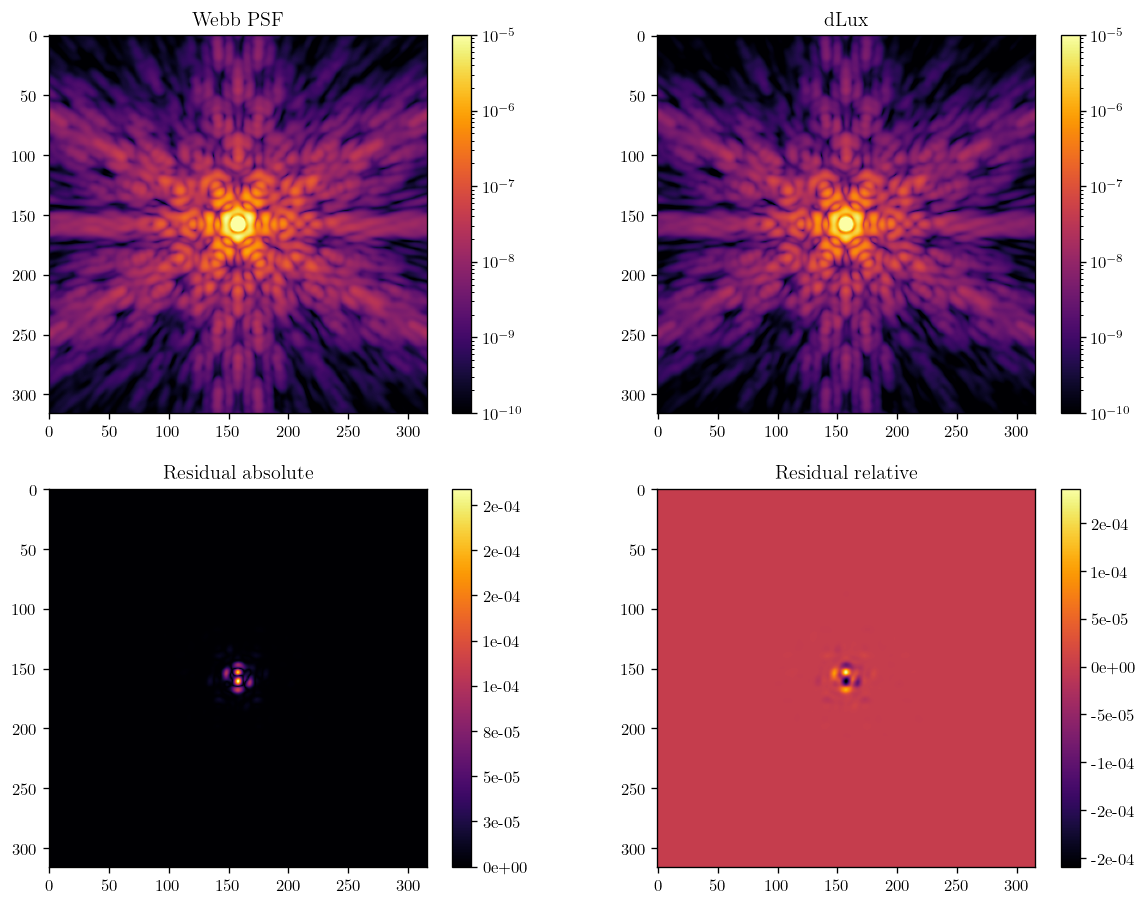

In [42]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.title("Webb PSF")
plt.imshow(webbpsf_data/100, norm=norm)
bar1 = plt.colorbar()
#bar1.set_ticks(ticks)
#bar1.set_ticklabels(ticks)

plt.subplot(2, 2, 2)
plt.title("dLux")
plt.imshow(psf/100, norm=norm)
bar2 = plt.colorbar()
#bar2.set_ticks(ticks)
#bar2.set_ticklabels(ticks)

plt.subplot(2, 2, 3)
plt.title("Residual absolute")
plt.imshow(abs(webbpsf_norm - psf_norm))
# plt.imshow(webbpsf_norm/psf_norm)
plt.colorbar(format='%.0e')

plt.subplot(2, 2, 4)
plt.title("Residual relative")
plt.imshow(webbpsf_norm - psf_norm)
# plt.imshow(webbpsf_norm/psf_norm)
plt.colorbar(format='%.0e')


# Let's make plots for every mirror fixed 

316.0
0.01575 arcsec / pix
Modeling mirror 0
Modelling optics...
Modelling optics...ok


Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

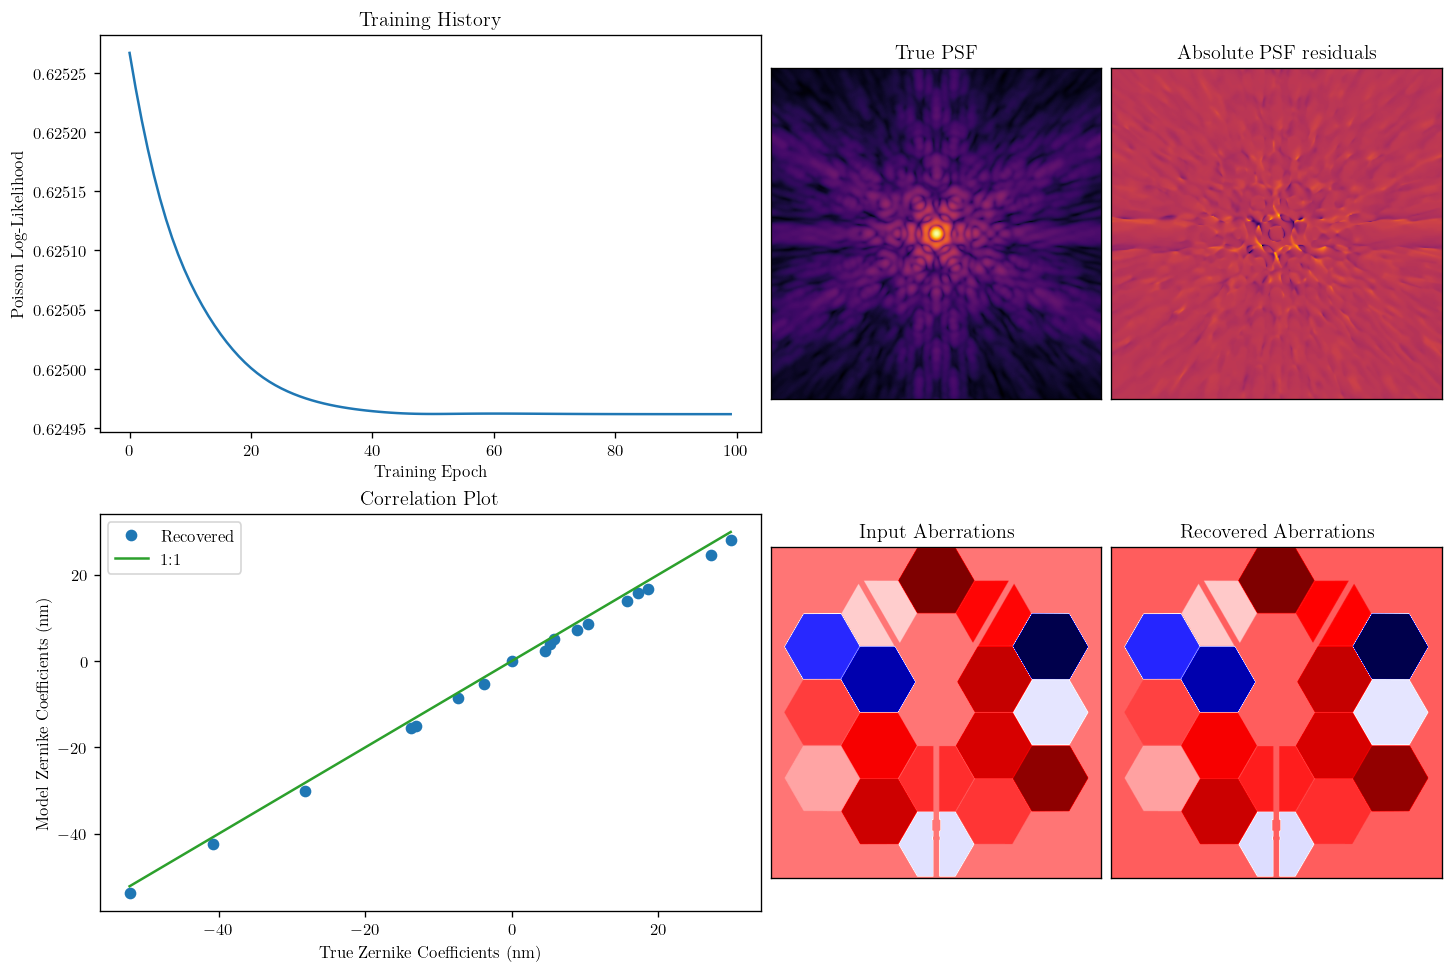

Modeling mirror 1
Modelling optics...


2023-04-28 14:57:03.075845: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce.117 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-04-28 14:57:03.603366: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.532542s
Constant folding an instruction is taking > 1s:

  reduce.117 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off bet

Modelling optics...ok


Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

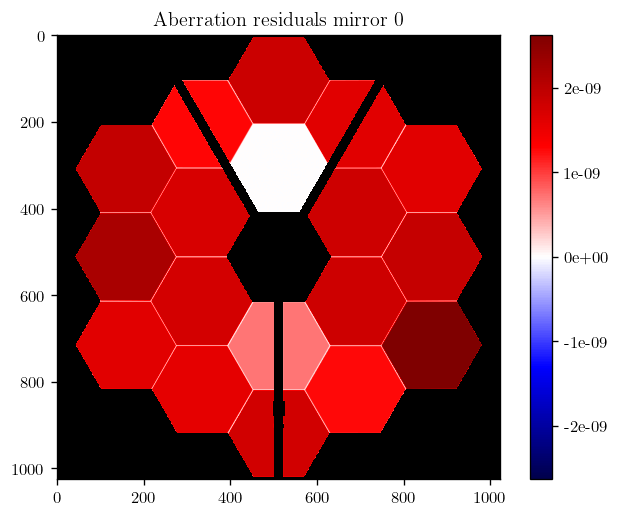

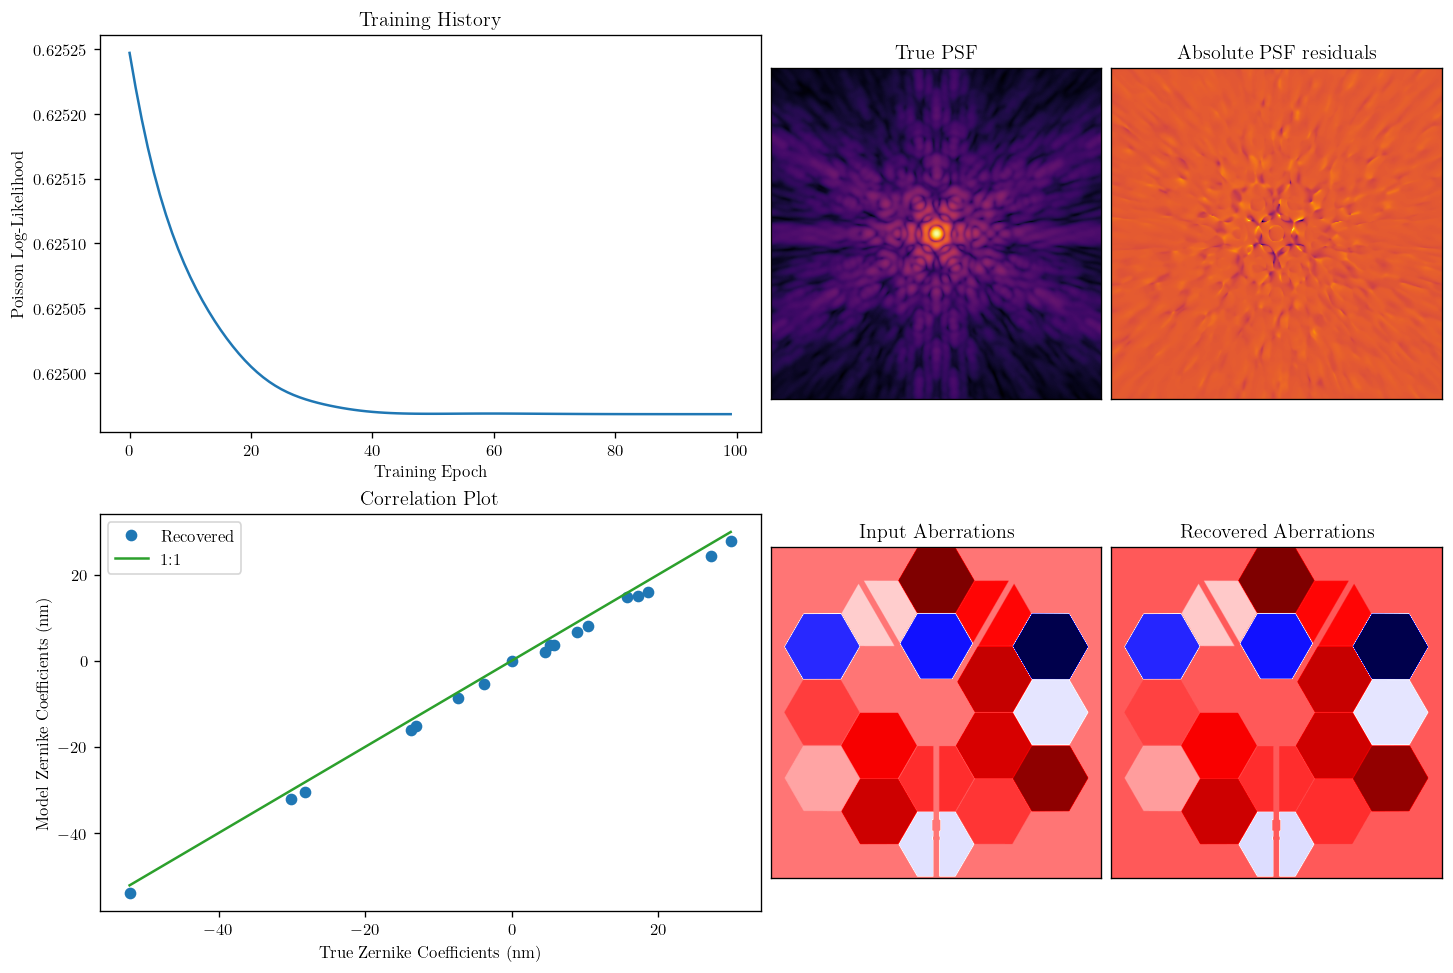

Modeling mirror 2
Modelling optics...
Modelling optics...ok


Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

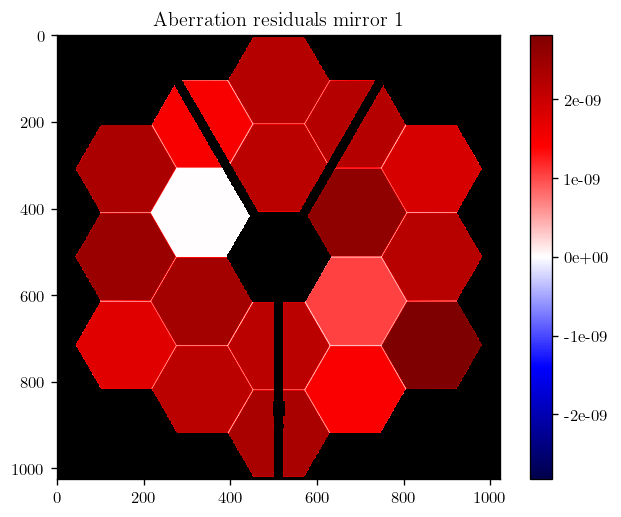

In [48]:
seed = 0xDEFDBE3F
initial_seed = 0xBED145

cmap = colormaps['seismic']
cmap.set_bad('k',1.)
cmap1 = colormaps['seismic']
cmap1.set_bad('k',1.)

n_mir = 0

true_zern = []
recovered_zern = []

# Wavefront 
npix = 1024
diameter = pupil_plane.pixelscale.to('m/pix').value * pupil_plane.npix

# Aperture and OPD
webb_aper = nircam.planes[0].amplitude
webb_opd = nircam.planes[0].opd
pupil_mask = nircam.planes[3].amplitude

# Detector
det_npix = (det_plane.fov_pixels * det_plane.oversample).value
print(det_npix)
pscale = det_plane.pixelscale/det_plane.oversample
print(pscale)
pscale = pscale.to('radian/pix').value

def get_optical_layers(basis, coeffs):
    optical_layers = [

        #Plane 0: Pupil plane: JWST Entrance Pupil
        dl.CreateWavefront(npix, diameter, 'Angular'),
        dl.TransmissiveOptic(webb_aper),
        dl.AddOPD(webb_opd),
        JWST_basis(basis, coeffs),

        #Plane 1: Coordinate Inversion in y axis
        InvertY(),

        #Plane 2: Pupil plane: NIRCamLWA internal WFE at V2V3=(1.46,-6.75)', near Z430R_A
        dl.TransmissiveOptic(nircam.planes[2].amplitude),
        NIRCamFieldAndWavelengthDependentAberration(webb_osys, nircam.planes[2].opd, nircam.planes[2].zernike_coeffs),


        #Plane 3: Detector plane: NIRCam detector (79x79 pixels, 0.063 arcsec / pix)
        dl.AngularMFT(det_npix, pscale),         

    ]
    return optical_layers


for n_mir in range(18):
    
    # Create a modeled coeffs array
    coeffs = 2e-8*jr.normal(jr.PRNGKey(seed), (basis_flat.shape[0],))
    coeffs = coeffs.at[n_mir].set(0)
    
    base_aberrations = get_aber(coeffs, basis_flat)
    
    print(f"Modeling mirror {n_mir}")
    
    # make layers
    optical_layers = get_optical_layers(basis_flat, coeffs)

    optics = dl.Optics(optical_layers)

    telescope = dl.Instrument(optics, source)

    @jit
    def model_optics_jit():
        return telescope.model()
    
    print("Modelling optics...")
    psf = model_optics_jit()
    print("Modelling optics...ok")
    psf_norm = psf/psf.sum()

    # Define path to the zernikes
    zernikes = 'JWST_basis.coeffs'

    # Generate new random set of zernikes
    coeffs_init_random = 2e-8*jr.normal(jr.PRNGKey(initial_seed), (basis_flat.shape[0],))

    # Generate a new model with updated zernike coefficients
    
    true_coeffs = telescope.get(zernikes) # =coeffs
    init_coeffs = coeffs_init_random
    init_coeffs = init_coeffs.at[n_mir].set(0)
    
    model = telescope.set(zernikes, init_coeffs)
    
    @zdx.filter_jit
    @zdx.filter_value_and_grad(zernikes)
    def loss_func(model, data):
        out = model.model()
        return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

    loss, initial_grads = loss_func(model, psf*1e6) # Compile
    
    optim, opt_state = zdx.get_optimiser(model, [zernikes], [optax.adam(2e-9)])

    losses, models_out = [], []
    with tqdm(range(100), desc='Gradient Descent') as t:
        for i in t: 
            # calculate the loss and gradient
            loss, grads = loss_func(model, psf)
            
            vector = np.ones(18) #set up grads of fixed mirror to 0 when applies update
            vector = vector.at[n_mir].set(0.)
            grads = grads.multiply('JWST_basis.coeffs', vector)

            # apply the update
            updates, opt_state = optim.update(grads, opt_state)
            model = zdx.apply_updates(model, updates)

            # save results
            models_out.append(model) 
            losses.append(loss)

            t.set_description('Loss %.7f' % (loss)) # update the progress bar
            
    final_psf = model.model()

    model_basis = np.asarray((model.JWST_basis.basis).reshape((18, npix_basis, npix_basis)), dtype=float)
    model_coeffs = np.asarray((model.JWST_basis.coeffs).reshape(model.JWST_basis.coeffs.shape[0], 1, 1), dtype=float)
    model_result = model_coeffs* model_basis
    model_result.sum(0).shape
    
    coeffs_out = np.array([model_out.get(zernikes) for model_out in models_out])

    
    # Make plots
    
    mosaic = """
        AABD
        GGEF
        """

    fig = plt.figure(constrained_layout=True,figsize=(12, 8))
    axes = fig.subplot_mosaic(mosaic)

    for ax in ['B','D','E','F']:
        axes[ax].set_xticks([])
        axes[ax].set_yticks([])

    axes['A'].plot(np.log10(np.array(losses)))
    axes['A'].set_title("Training History")
    axes['A'].set_xlabel('Training Epoch')
    axes['A'].set_ylabel('Poisson Log-Likelihood')

    axes['B'].imshow(psf**0.1)
    axes['B'].set_title('True PSF')

    axes['G'].plot(coeffs*1e9,model_coeffs.reshape(18,)*1e9,'.',markersize=12,color='C0',label='Recovered')

    axes['G'].plot(np.array([np.min(coeffs),np.max(coeffs)])*1e9,
                   np.array([np.min(coeffs),np.max(coeffs)])*1e9,
                   '-',color='C2',label='1:1')
    axes['G'].legend()
    axes['G'].set_title('Correlation Plot ')
    axes['G'].set_xlabel('True Zernike Coefficients (nm)')
    axes['G'].set_ylabel('Model Zernike Coefficients (nm)')

    axes['D'].imshow(final_psf**0.1 - psf**0.1)
    axes['D'].set_title('Absolute PSF residuals')

    axes['E'].imshow(mask*base_aberrations, cmap=cmap)
    axes['E'].set_title('Input Aberrations')

    axes['F'].imshow(mask*model_result.sum(0), cmap=cmap)
    axes['F'].set_title('Recovered Aberrations')
    plt.show()
    
    filename0 = f"fixed_mirror_general_plot_{n_mir}.png"
    filepath0 = os.path.join("plots", filename0)  # Change "plots" to your desired folder name
    fig.savefig(filepath0)
    
    input_mask = (np.where(mask==0, np.nan, mask))
    data = input_mask*(base_aberrations - model_result.sum(0))

    val_max = np.max(np.abs(base_aberrations - model_result.sum(0)))
    norm1 = colors.TwoSlopeNorm(vmin=-val_max, vmax=val_max, vcenter=0)
    
    fig_res, ax_res = plt.subplots()
    im = ax_res.imshow(mask*data, cmap=cmap1, norm=norm1)
    ax_res.set_title(f'Aberration residuals mirror {n_mir}')
    fig_res.colorbar(im,format='%.0e')
    
    # Save the plot to a file
    filename = f"fixed_mirror_{n_mir}.png"
    filepath = os.path.join("plots_residuals", filename)  # Change "plots" to your desired folder name
    fig_res.savefig(filepath)

    # Close the plot to release memory
    plt.close(fig)
    
    true_zern.append(coeffs) 
    recovered_zern.append(model_coeffs)
    
    

In [126]:
true_zern_ = true_zern
recovered_zern_ = recovered_zern

In [127]:
indices = np.arange(18)
counter_indices = [3,4,5,0,1,2,9,10,11,6,7,8,15,16,17,12,13,14]

In [134]:
for n in np.arange(len(indices)):
    print(f'Mirrors {indices[n]} - {counter_indices[n]}')
    
    
    all_mir_offset = np.average(recovered_zern_[n])
    true_opd_sym = true_zern_[n][counter_indices[n]]
    test_sym_opd = true_opd_sym - all_mir_offset
    sym_opd = recovered_zern_[n][counter_indices[n]]
    
    print(f'all mirror offset: {all_mir_offset}')
    print(f'True OPD to sym morror: { true_opd_sym}')
    print(f'True OPD sym - offset: {test_sym_opd}')
    print(f'Recovered OPD sym mirror: {sym_opd}')
    print('  ')
    
   # diff = recovered_zern_[n][indices[n]] - recovered_zern_[n][counter_indices[n]]
   # true_val_counter = true_zern_[n][counter_indices[n]]
   # print("difference between recovered zern and it's recovered counterpart:")
   # print(f'{diff[n]}')
   # print("True value of counterpart:")
   # print(f'{true_val_counter}')     
   # print('  ')
                                
    
    print

Mirrors 0 - 3
all mirror offset: 1.0198189387679683e-08
True OPD to sym morror: 5.788729506253387e-09
True OPD sym - offset: -4.409459881426296e-09
Recovered OPD sym mirror: [[2.85829685e-08]]
  
Mirrors 1 - 4
all mirror offset: 1.3898248659788009e-08
True OPD to sym morror: 1.5708119887807097e-08
True OPD sym - offset: 1.8098712280190885e-09
Recovered OPD sym mirror: [[4.51934813e-08]]
  
Mirrors 2 - 5
all mirror offset: -8.111782609978407e-09
True OPD to sym morror: 1.854372950737604e-08
True OPD sym - offset: 2.665551211735445e-08
Recovered OPD sym mirror: [[9.69804318e-09]]
  
Mirrors 3 - 0
all mirror offset: -6.2496487108775824e-09
True OPD to sym morror: -3.0103091760204554e-08
True OPD sym - offset: -2.385344304932697e-08
Recovered OPD sym mirror: [[-3.46179821e-08]]
  
Mirrors 4 - 1
all mirror offset: -1.1944035774847513e-08
True OPD to sym morror: -4.0772647180721554e-08
True OPD sym - offset: -2.882861140587404e-08
Recovered OPD sym mirror: [[-5.38994658e-08]]
  
Mirrors 5 - 

In [ ]:
#zernikes_out = np.array([model.JWST_basis.coeffs.reshape(model.JWST_basis.coeffs.shape[0]) for model in models_out])

# 6 x 3 subplots
#fig, axes = plt.subplots(6, 3, figsize=(12, 12),sharex=True,sharey=True)

#for j in range(18):
#    ax = axes.ravel()[j]
#    ax.plot(zernikes_out[:,j]*1e9)
#    ax.axhline(coeffs[j]*1e9,color='k',linestyle='--',alpha=0.5)
#   ax.set_title('Mirror %d' % (j+1))
#    ax.set_ylabel('OPD (nm)')
#    if j>14:
#        ax.set_xlabel('Epoch')
